# $\textit{Data Exploration}$

In [2]:
import helper as hp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper
import importlib
importlib.reload(helper)
sns.set_theme()

In [3]:
train_X, test_X, train_y, test_y, train, test, labels, classes = hp.initData() #Getting test and train data

In [4]:
train_X, train_y = hp.augmentData(train_X, train_y)

Text(0.5, 1.0, 'Data Distribution')

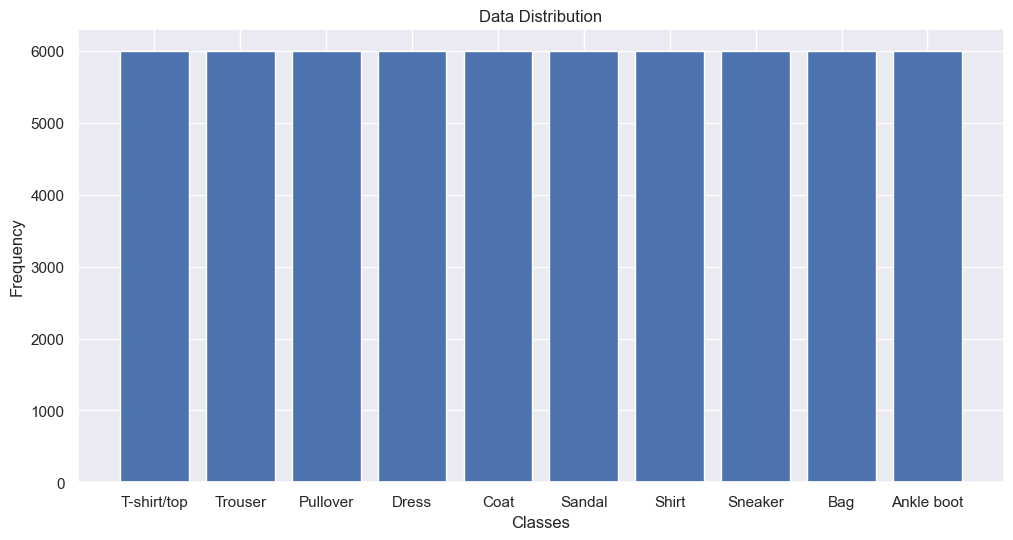

In [4]:
num, frequency = np.unique(labels, return_counts=True)
plt.bar(classes, frequency)
plt.gcf().tight_layout(pad=0)
plt.gcf().set_figwidth(10)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Data Distribution")

$\textit{Notamos que la distribucion de clases es uniformemente.}$

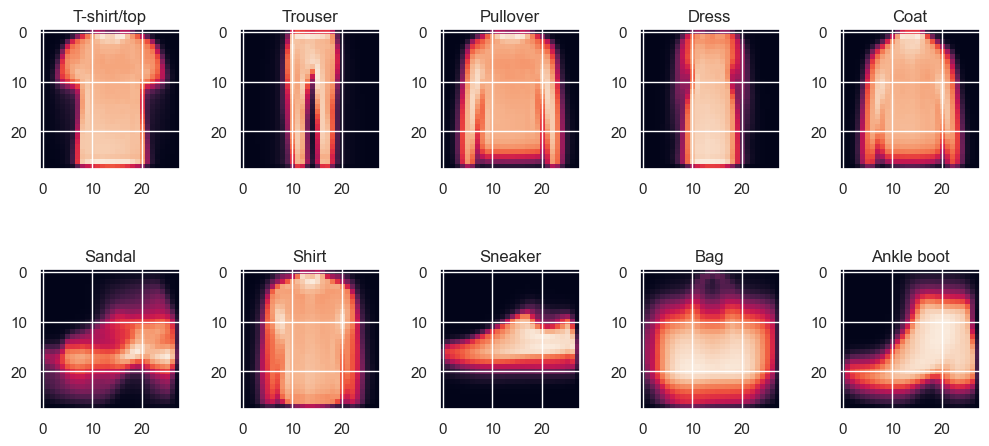

In [32]:
fig, axs = plt.subplots(2, 5)
fig.tight_layout(pad=0)
fig.set_figwidth(10)
train = np.load("./Data/train_images.npy")
meanImg = [train[labels.label.values == k].mean(axis=0).reshape(28,28) for k in range(10)]
for i in range(2):
    for j in range(5):
        axs[i][j].set_title(classes[5*i+j])
        axs[i][j].imshow(meanImg[5*i+j])

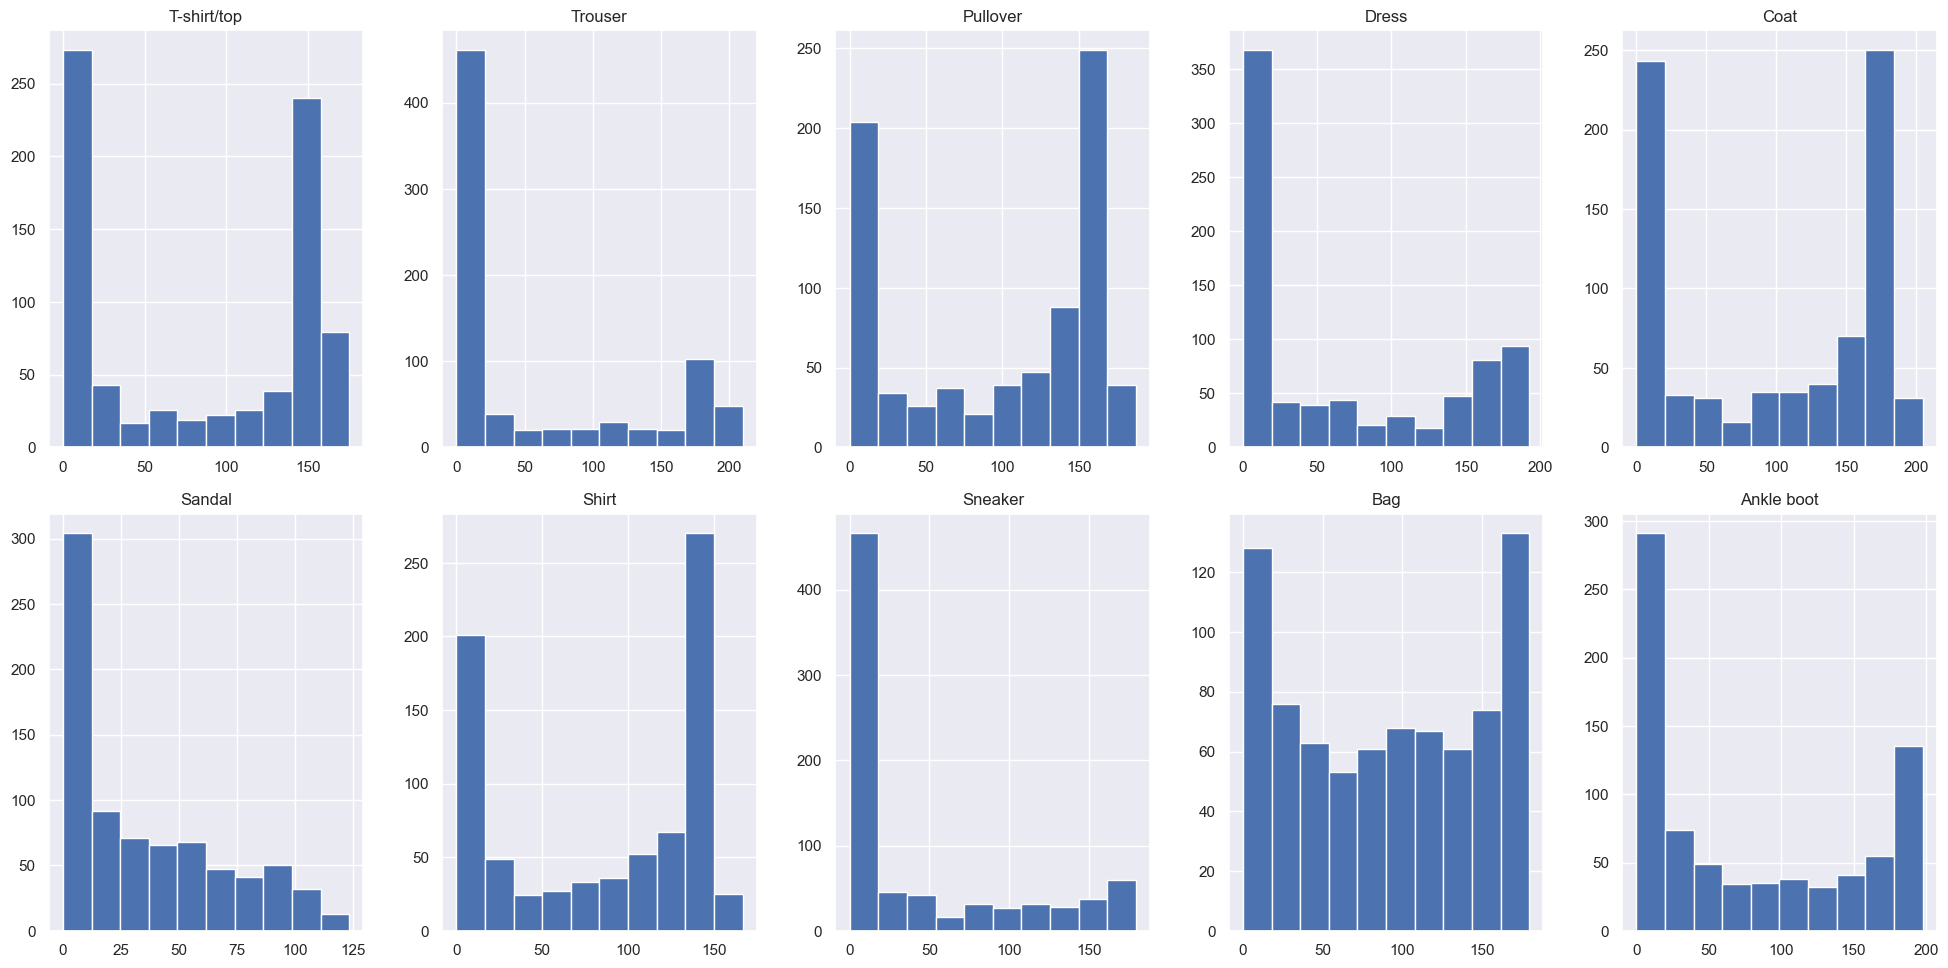

In [35]:
fig, axs = plt.subplots(2, 5, figsize=(20,10))
fig.tight_layout(pad=2)
meanImg = [train[labels.label.values == k].mean(axis=0).reshape(28,28) for k in range(10)]
for i in range(2):
    for j in range(5):
        axs[i][j].set_title(classes[5*i+j])
        lst = meanImg[5*i+j].flatten()
        axs[i][j].hist(lst)

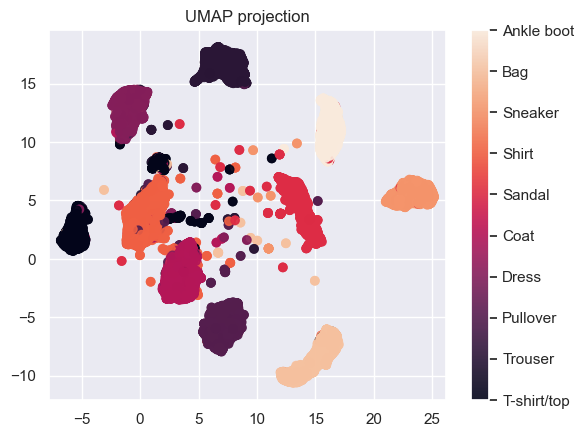

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap

data = np.load("./Data/train_images.npy")
data = data/255
data = data.reshape(data.shape[0], -1) 
labels = pd.read_csv("./Data/train_labels.csv").values

embedding = umap.UMAP().fit_transform(data, y=labels)

plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, alpha=0.9)
plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(ticks=np.arange(10))
cbar.ax.set_yticklabels(classes)
plt.title('UMAP projection')
plt.show()

# $\textit{Model Exploration}$

In [5]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Nadam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, RandomNormal
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras import Model

In [6]:
y_sparse_train = [[0 if train_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(train_y))]
y_sparse_train = np.array(y_sparse_train)
y_sparse_test = [[0 if test_y[i]!=j else 1 for j in range(len(classes))] for i in range(len(test_y))]
y_sparse_test = np.array(y_sparse_test)

$\textit{Base model (before enhancement)}$

In [43]:
callbackES = EarlyStopping(monitor="val_categorical_accuracy", patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(BatchNormalization())
model.add(Dense(50, activation="relu", kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 43,096
Trainable params: 41,428
Non-traina

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [54]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0002), metrics=[CategoricalAccuracy(), AUC(), Precision(), Recall()])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 32, epochs=20)
model.save("./Model/FashionMNISTBase")

Epoch 1/20
3125/3125 [==============================] - 10s 3ms/step - loss: 0.2689 - categorical_accuracy: 0.9014 - auc_3: 0.9950 - precision_1: 0.9169 - recall_1: 0.8862 - val_loss: 0.3446 - val_categorical_accuracy: 0.8789 - val_auc_3: 0.9910 - val_precision_1: 0.8949 - val_recall_1: 0.8664
Epoch 2/20
3125/3125 [==============================] - 8s 2ms/step - loss: 0.2666 - categorical_accuracy: 0.9014 - auc_3: 0.9951 - precision_1: 0.9169 - recall_1: 0.8866 - val_loss: 0.3436 - val_categorical_accuracy: 0.8807 - val_auc_3: 0.9911 - val_precision_1: 0.8967 - val_recall_1: 0.8692
Epoch 3/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.2631 - categorical_accuracy: 0.9031 - auc_3: 0.9951 - precision_1: 0.9185 - recall_1: 0.8885 - val_loss: 0.3417 - val_categorical_accuracy: 0.8804 - val_auc_3: 0.9908 - val_precision_1: 0.8941 - val_recall_1: 0.8671
Epoch 4/20
3125/3125 [==============================] - 7s 2ms/step - loss: 0.2613 - categorical_accuracy: 0.9042 - a

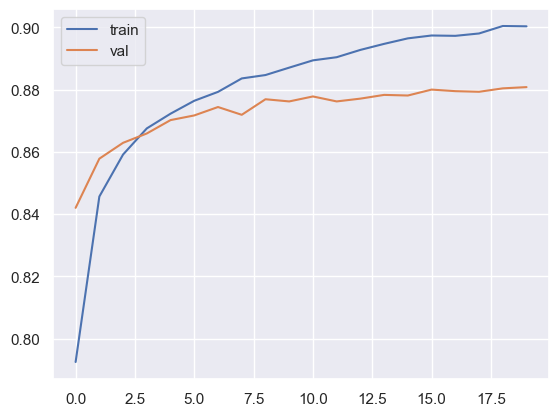

In [52]:
plt.plot(history.history["categorical_accuracy"], label="train")
plt.plot(history.history["val_categorical_accuracy"], label="val")
plt.legend()
plt.show()

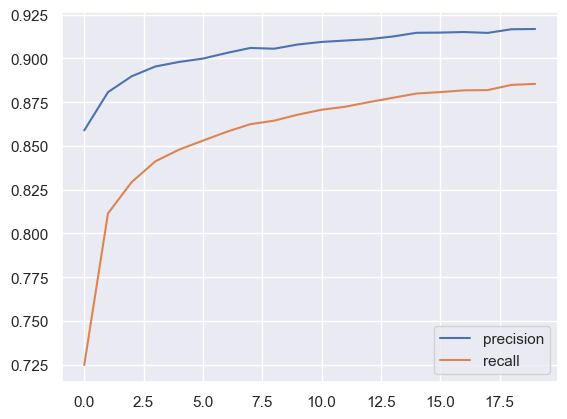

In [47]:
plt.plot(history.history["precision"], label="precision")
plt.plot(history.history["recall"], label="recall")
plt.legend()
plt.show()

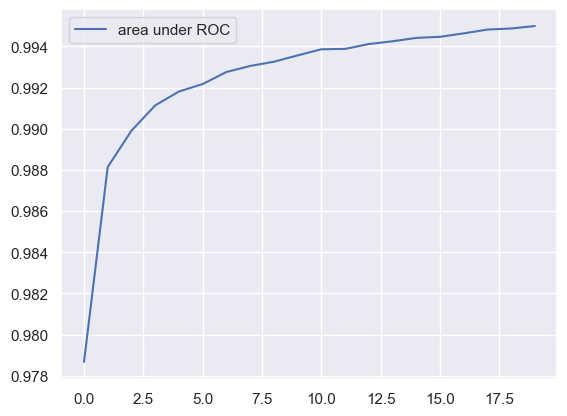

In [48]:
plt.plot(history.history["auc"], label="area under ROC")
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


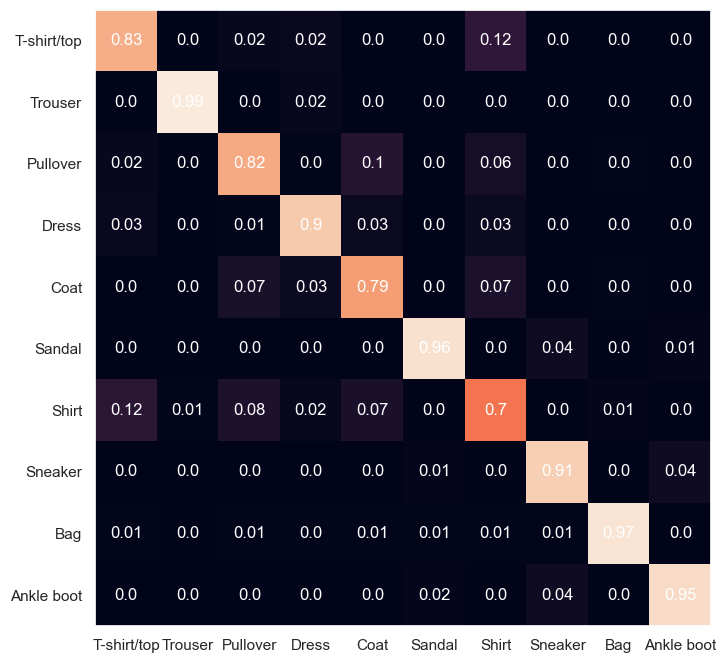

In [49]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(test_X)
y_prediction = np.argmax(y_prediction, axis = 1)
result = confusion_matrix(test_y, y_prediction, normalize='pred')

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(result)
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
plt.grid(None)

# Loop over data dimensions and create text annotations.
for i in range(len(result)):
    for j in range(len(result)):
        text = ax.text(j, i, np.round(result[i, j],2),
                       ha="center", va="center", color="w")

In [50]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_prediction, digits=3))

              precision    recall  f1-score   support

           0      0.831     0.840     0.835      1023
           1      0.986     0.977     0.981       988
           2      0.821     0.801     0.811      1008
           3      0.897     0.900     0.899      1021
           4      0.790     0.831     0.810      1050
           5      0.960     0.941     0.950       996
           6      0.700     0.677     0.689       970
           7      0.915     0.945     0.929       955
           8      0.969     0.957     0.963       968
           9      0.945     0.943     0.944      1021

    accuracy                          0.881     10000
   macro avg      0.881     0.881     0.881     10000
weighted avg      0.881     0.881     0.881     10000



$\textit{En la tabla anterior podemos observar el macro F1-score = 0.881}$

Para cualquier metrica, el micro y el macro average se calculan ligeramente diferente. El macro average computa la metrica de forma independiente para cada clase y luego trata a cada clase por igual, mientras que el micro average toma en cuenta la contribucion de cada clase para calcular el resultado. Por esto, en clasificacion multiclase es preferible usar micro average si se sospecha que puede existir un imbalance de clases, es decir que pueda predominar la aparicion de una clase frente a las demas durante el entrenamiento. Dicho esto, la metrica mas correcta a calcular en este caso es el macro average, ya que el balance de clase es uniforme por lo visto en el histograma de clases y para este caso el micro average daria igual como se observa en la tabla de arriba donde aparece como "weighted avg".

In [368]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_pred1 = model.predict(test_X)
y_pred = np.argmax(y_pred1, axis=1)

p = precision_score(test_y, y_prediction , average="macro")
r = recall_score(test_y, y_prediction , average="macro")
f1 = f1_score(test_y, y_prediction , average="macro")
# Print f1, precision, and recall scores
print(f"macro precision: {p:.5f}")
print(f"macro recall: {r:.5f}")
print(f"macro f1-score: {f1:.5f}")

313/313 [==============================] - 0s 1ms/step
macro precision: 0.88139
macro recall: 0.88109
macro f1-score: 0.88111


# $\textit{Model Enhancement}$

## $\textit{Accuracy vs LR}$

La prueba se realizo dos veces para un ajuste mas fino del LR. Se observa del grafico obtenido que existe un valor de learning rate optimo en el cual la red se aproxima a un mejor accuracy sin diverger. En otros casos los valores son o muy grandes para converger a un accuracy mas cercano al minimo o muy pequeños como para llegar a un accuracy mayor en pocos steps.

In [121]:
model = load_model("./Model/FashionMNISTBase")
lr = 0.0000016
acc_valResults = []

for i in range(10):
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=lr), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 32, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    lr = lr/5


Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2576 - accuracy: 0.9070 - val_loss: 0.3423 - val_accuracy: 0.8808
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2499 - accuracy: 0.9085 - val_loss: 0.3463 - val_accuracy: 0.8817
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2473 - accuracy: 0.9112 - val_loss: 0.3467 - val_accuracy: 0.8825
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9106 - val_loss: 0.3672 - val_accuracy: 0.8819
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2448 - accuracy: 0.9121 - val_loss: 0.3427 - val_accuracy: 0.8826
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2440 - accuracy: 0.9118 - val_loss: 0.3438 - val_accuracy: 0.8835
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2442 - accuracy: 0.9114 - val_loss: 0.3611 - val_accuracy:

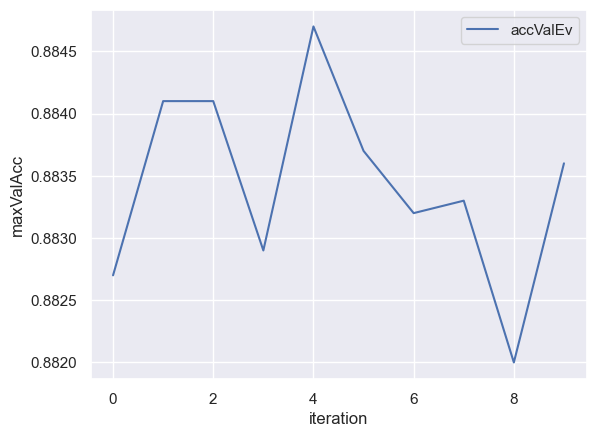

In [122]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## $\textit{Accuracy vs Batchsize}$


Se encontro que el batchsize optimo esta alrededor de los 64-128. Se investigaron varias fuentes y se encontro que mayores batchsizes implican menor accuracy. Esto es porque a menor bathsize, el ruido estadistico provoca que usando metodos como SGD, el vector de pesos pueda salir de zonas de minimos locales y evolucionar hacia otras zonas.

In [134]:
bz = 32
acc_valResults = []

for i in range(5):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = bz, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])
    bz = bz*2

Epoch 1/10
1563/1563 [==============================] - 5s 2ms/step - loss: 0.2638 - accuracy: 0.9051 - val_loss: 0.3458 - val_accuracy: 0.8823
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2567 - accuracy: 0.9078 - val_loss: 0.3463 - val_accuracy: 0.8824
Epoch 3/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2581 - accuracy: 0.9062 - val_loss: 0.3385 - val_accuracy: 0.8831
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2569 - accuracy: 0.9084 - val_loss: 0.3397 - val_accuracy: 0.8830
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2550 - accuracy: 0.9077 - val_loss: 0.3392 - val_accuracy: 0.8832
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2533 - accuracy: 0.9099 - val_loss: 0.3403 - val_accuracy: 0.8827
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2547 - accuracy: 0.9086 - val_loss: 0.3396 - val_accuracy:

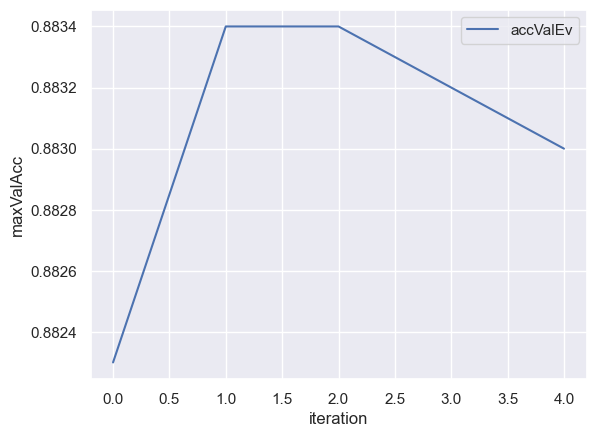

In [135]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## $\textit{Accuracy vs Optimizers}$


Por lo visto en clase, se concluye que tanto Adam como RMSprop performan de forma similar. No se agrego Nadam a la lista porque no se conocia su funcionamiento al momento de realizar el codigo. Sin embargo, se agrego al modelo mejorado gracias a sus capacidades de convergencia.

In [136]:
opts = [SGD(0.0000016), RMSprop(0.0000016), Adam(0.0000016), Adagrad(0.0000016)]
acc_valResults = []

for i in range(4):
    model = load_model("./Model/FashionMNISTBase")
    model.compile(loss = CategoricalCrossentropy(), optimizer=opts[i], metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), batch_size = 64, epochs=10)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2457 - accuracy: 0.9108 - val_loss: 0.3537 - val_accuracy: 0.8798
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3454 - val_accuracy: 0.8801
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3430 - val_accuracy: 0.8805
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2462 - accuracy: 0.9105 - val_loss: 0.3443 - val_accuracy: 0.8805
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2460 - accuracy: 0.9105 - val_loss: 0.3437 - val_accuracy: 0.8804
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2455 - accuracy: 0.9111 - val_loss: 0.3427 - val_accuracy: 0.8806
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2451 - accuracy: 0.9116 - val_loss: 0.3431 - val_accuracy: 0.8812
Epoch 

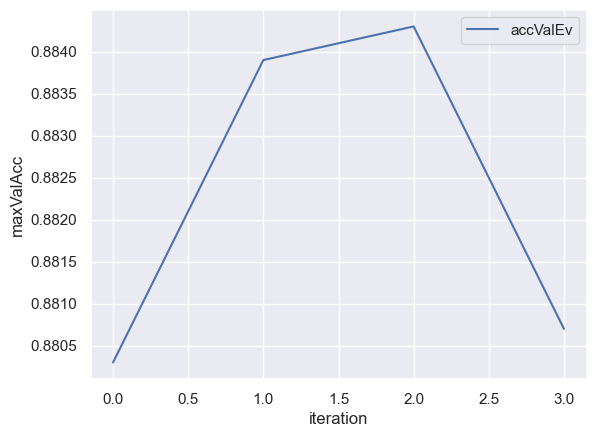

In [137]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

## $\textit{Accuracy vs Activations}$

Se nota una gran similitud entre las activaciones relu y elu, esto se debe a que los limites que puede formar entre ellas son muy similares. Por otro lado, funciones acotadas como sigmoid y tanh fueron las que peor funcionaron para el modelo. Se desconoce porque la activacion selu no tuvo un comportamiento similar a las primeras dos mencionadas. 

In [153]:
activs = ["exponential", "relu", "elu", "sigmoid", "tanh", "selu"]

for i in range(len(activs)):
    callbackES = EarlyStopping(monitor='accuracy', patience=3)
    initializer = GlorotNormal()
    model = Sequential()
    model.add(Flatten(input_shape=(28,28)))
    model.add(BatchNormalization())
    model.add(Dense(40, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
    model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(0.0000016), metrics=["accuracy"])
    history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES], batch_size = 64, epochs=100)
    acc_valResults.append(history.history["val_accuracy"][-1])

Epoch 1/100
782/782 [==============================] - 4s 4ms/step - loss: 2.8342 - accuracy: 0.1132 - val_loss: 6.0838 - val_accuracy: 0.1407
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 2.5147 - accuracy: 0.1796 - val_loss: 8.7870 - val_accuracy: 0.2162
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 2.2484 - accuracy: 0.2506 - val_loss: 5.9614 - val_accuracy: 0.3128
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 2.0337 - accuracy: 0.3242 - val_loss: 4.8690 - val_accuracy: 0.3816
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 1.8732 - accuracy: 0.3796 - val_loss: 668.4653 - val_accuracy: 0.4229
Epoch 6/100
782/782 [==============================] - 3s 4ms/step - loss: 1.7445 - accuracy: 0.4277 - val_loss: 2.4605 - val_accuracy: 0.4649
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 1.6435 - accuracy: 0.4660 - val_loss: 5.7447 - val_accuracy: 0.49

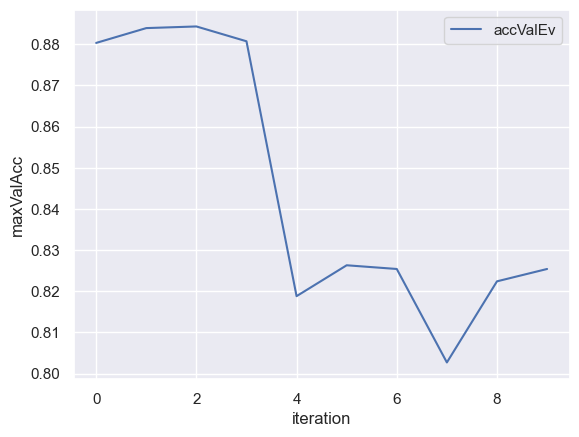

In [154]:
plt.plot(acc_valResults, label="accValEv")
plt.xlabel("iteration")
plt.ylabel("maxValAcc")
plt.legend()
plt.show()

# $\textit{Model Enhanced Analysis}$

$\textit{Entrenamos un modelo teniendo en cuenta el analisis previo de hiperparametros}$
$\textit{Ademas, se agregaron nuevos hiperparametros aprendidos durante las clases}$

In [8]:
import tensorflow_addons as tfa
import tensorflow as tf

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
BATCH_SIZE = 64
INIT_LR = 0.0002
MAX_LR = 0.002

In [12]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      max_lr = MAX_LR)


callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer))
model.summary()
model.load_weights("./Weight/red3.h5")
w1 = model.get_weights()
callbackP = helper.PruningCallback(w1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout_2 (Dropout)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [13]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Nadam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP, callbackP], batch_size = BATCH_SIZE, epochs=200)
model.save("./Model/FashionMNISTEnhanced")

Epoch 1/200
1563/1563 [==============================] - 9s 5ms/step - loss: 0.6659 - accuracy: 0.7703 - val_loss: 0.4668 - val_accuracy: 0.8329 - lr: 0.0011
Epoch 2/200
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4496 - accuracy: 0.8378 - val_loss: 0.4017 - val_accuracy: 0.8574 - lr: 0.0020
Epoch 3/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3955 - accuracy: 0.8543 - val_loss: 0.3605 - val_accuracy: 0.8705 - lr: 0.0011
Epoch 4/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3565 - accuracy: 0.8679 - val_loss: 0.3324 - val_accuracy: 0.8789 - lr: 2.0086e-04
Epoch 5/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3405 - accuracy: 0.8758 - val_loss: 0.3393 - val_accuracy: 0.8767 - lr: 6.5115e-04
Epoch 6/200
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3452 - accuracy: 0.8714 - val_loss: 0.3356 - val_accuracy: 0.8762 - lr: 0.0011
Epoch 7/200
1563/1563 [=====================

INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


INFO:tensorflow:Assets written to: ./Model/FashionMNISTEnhanced\assets


# $\textit{Pruning}$

$\textit{red1: Contiene los pesos de la red sin entrenar}$
$\textit{red2: Contiene los pesos de la red entrenada. Acc = 0.895}$ 
$\textit{red3 (Sin entrenar): Se obtuvo un Acc = 0.159}$
$\textit{red3 (Entrenada): Se obtuvo un Acc = 0.891}$

In [28]:
model.load_weights(filepath="./Weight/red1.h5", by_name=True)
w1 = model.get_weights()
model.load_weights(filepath="./Weight/red2.h5", by_name=True)
w2 = model.get_weights()

# Compute the absolute element-wise difference between w1 and w2
weight_changes = np.abs(np.array(w1, dtype=object) - np.array(w2, dtype=object))

acc = 0
n = 0
for layer in weight_changes:
    for weightl in layer:
        if not isinstance(weightl, np.floating):
            for w in weightl:
                acc += w
                n += 1
threshold = acc/n

# Iterate through the weights and set values to zero if the change is below the threshold
pruned_weights = []
for w, change in zip(w1, weight_changes):
    pruned_weights.append(np.where(change >= threshold, w, 0.0))
    
model.set_weights(pruned_weights)
model.save_weights("./Weight/red3.h5")

In [15]:
predictions = model.predict(test_X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = predicted_labels.reshape(-1,1)
accuracy = (predicted_labels == test_y).sum() / test_y.size
print("The overall agreement is %.3f" % accuracy)

313/313 [==============================] - 1s 1ms/step
The overall agreement is 0.891


## $\textit{Aditionals}$

In [25]:
steps_per_epoch = len(train_X) // BATCH_SIZE
callbackCLR = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)

callbackROP = ReduceLROnPlateau(monitor="val_accuracy",
                      factor = 0.1,
                      verbose= 1,
                      pacience = 20,
                      min_lr = MAX_LR)

callbackES = EarlyStopping(monitor='val_accuracy', patience=10)
initializer = GlorotNormal()
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="elu", kernel_initializer=initializer))
model.add(Dropout(0.1))
model.add(Dense(2, kernel_initializer=initializer, name='twinCity'))
model.add(Dense(10, activation="softmax", kernel_initializer=initializer, name='soft'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dropout_2 (Dropout)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 twinCity (Dense)            (None, 2)                 202       
                                                                 
 soft (Dense)                (None, 10)                30        
                                                                 
Total params: 78,732
Trainable params: 78,732
Non-trai

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [26]:
model.compile(loss = CategoricalCrossentropy(), optimizer=Adam(callbackCLR), metrics=["accuracy"])
history = model.fit(x= train_X, y = y_sparse_train, validation_data=(test_X, y_sparse_test), callbacks=[callbackES, callbackROP], batch_size = BATCH_SIZE, epochs=200)

Epoch 1/200
1563/1563 [==============================] - 6s 3ms/step - loss: 1.3135 - accuracy: 0.5202 - val_loss: 0.8849 - val_accuracy: 0.6819 - lr: 0.0011
Epoch 2/200
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8042 - accuracy: 0.7365 - val_loss: 0.6969 - val_accuracy: 0.7822 - lr: 0.0020
Epoch 3/200
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6613 - accuracy: 0.7864 - val_loss: 0.6116 - val_accuracy: 0.8031 - lr: 0.0011
Epoch 4/200
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5878 - accuracy: 0.8121 - val_loss: 0.5505 - val_accuracy: 0.8245 - lr: 2.0086e-04
Epoch 5/200
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5649 - accuracy: 0.8196 - val_loss: 0.5412 - val_accuracy: 0.8296 - lr: 6.5115e-04
Epoch 6/200
1563/1563 [==============================] - 4s 3ms/step - loss: 0.5596 - accuracy: 0.8193 - val_loss: 0.5471 - val_accuracy: 0.8225 - lr: 0.0011
Epoch 7/200
1563/1563 [=====================

<AxesSubplot:xlabel='x', ylabel='y'>

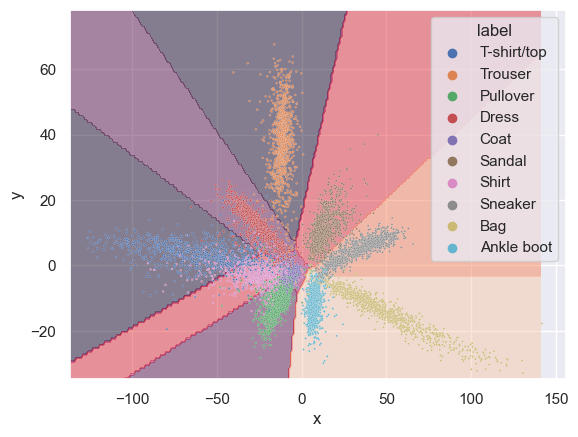

In [52]:
from matplotlib import cm

twoNeurons = 'twinCity'
out = 'soft'
intermediate_layer_model = Model(inputs=model.input,
                                    outputs=model.get_layer(twoNeurons).output)
intermediate_output = intermediate_layer_model(train_X)

x = intermediate_output[:, 0]
y = intermediate_output[:, 1]

boundaries_layer_model = Model(inputs=model.get_layer(twoNeurons).output,
                                outputs=model.output)

grid = np.meshgrid(np.arange(np.min(x), np.max(x), 1), np.arange(np.min(y), np.max(y), 1))
positions = np.append(grid[0].reshape(-1,1), grid[1].reshape(-1,1), axis=1)

bound = np.argmax(boundaries_layer_model(positions), (1))
bound = np.reshape(bound, grid[0].shape)

contour_plot = plt.contourf(grid[0], grid[1], bound, alpha=0.5)
data = pd.DataFrame()
data["x"] = x[:10000]
data["y"] = y[:10000]
data["label"] = labels[:10000]

num = np.unique(labels)
data = data.replace(num, classes, regex=True)
sns.scatterplot(
    x="x", y="y",
    hue="label",
    hue_order = classes,
    s = 2,
    data=data,
)